<a href="https://colab.research.google.com/github/Abhinav1771/Machine-learning/blob/main/streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q.1 Refer to the notebook on generating names using next-character prediction and modify it for generating text using next-word prediction (You have to implement MLP based text generator. However, it is recommended to refer to Andrej Karpathy’s blog post on the Effectiveness of RNNs).Visualize the embeddings using t-SNE if using more than 2 dimensions or using a scatter plot if using 2 dimensions and write your observations. Write a streamlit application that asks users for an input text, and it then predicts the next k words or lines. In the streamlit app, you should have controls for modifying context length, embedding dimension, activation function, random seed, etc. You can use any one of the datasets mentioned below.

**Device configuration**

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from sklearn.manifold import TSNE
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from pprint import pprint

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Using device: cpu


**Getting and processing the data**

In [ ]:
# Download the dataset
url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
response = requests.get(url)
text = response.text

# Preprocess text: remove special characters, convert to lowercase, etc.
text = re.sub('[^a-zA-Z0-9 \.]', '', text).lower()

# Split text into words
words = text.split()
print(f"Sample words: {words[:10]}")

# Filter out very short or very long words for a consistent vocabulary
words = [word for word in words if 2 < len(word) < 10]

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]

# Create vocabulary and mappings
unique_words = sorted(set(words))
vocab_size = len(unique_words)
stoi = {word: i for i, word in enumerate(unique_words)}
itos = {i: word for word, i in stoi.items()}

print(f"Vocabulary size: {vocab_size}")
pprint(itos)

Streaming output truncated to the last 5000 lines.
 4068: 'isas',
 4069: 'isaw',
 4070: 'iscapable',
 4071: 'iscorrect',
 4072: 'isderived',
 4073: 'ishall',
 4074: 'ishardly',
 4075: 'isherself',
 4076: 'ishould',
 4077: 'isimply',
 4078: 'island',
 4079: 'isle',
 4080: 'islight',
 4081: 'ismature',
 4082: 'ismost',
 4083: 'ismy',
 4084: 'isnot',
 4085: 'isnt',
 4086: 'isobvious',
 4087: 'isof',
 4088: 'isoff',
 4089: 'isoften',
 4090: 'isolated',
 4091: 'isolation',
 4092: 'isoon',
 4093: 'isover',
 4094: 'ispared',
 4095: 'issaid',
 4096: 'isscored',
 4097: 'isseared',
 4098: 'issmall',
 4099: 'issuch',
 4100: 'issue',
 4101: 'issues',
 4102: 'istarted',
 4103: 'isthat',
 4104: 'isthe',
 4105: 'isuddenly',
 4106: 'isuppose',
 4107: 'isvery',
 4108: 'iswhy',
 4109: 'iswrong',
 4110: 'isyour',
 4111: 'itagainst',
 4112: 'itah',
 4113: 'itall',
 4114: 'itbut',
 4115: 'itcrowded',
 4116: 'itdone',
 4117: 'itdown',
 4118: 'itell',
 4119: 'item',
 4120: 'items',
 4121: 'itexists',
 4122: 

**Defining hyperparams and creating a dataset for next word prediction**

In [ ]:
# Convert the text into a sequence of integer indices
data = [stoi[word] for word in words]

# Hyperparameters
block_size = 5  # Number of previous words to use as context
hidden_size = 1024

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create dataset for next-word prediction
def create_dataset(data, block_size):
    X, Y = [], []
    for i in range(len(data) - block_size):
        context = data[i:i + block_size]
        ix = data[i + block_size]

        # Print the context and next word in the desired format
        print(' '.join(itos[j] for j in context), '--->', itos[ix])

        X.append(context)
        Y.append(ix)

    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

# Generate X and Y with printed contexts and next words
X, Y = create_dataset(data, block_size)


Streaming output truncated to the last 5000 lines.
can hardly less from their ---> have
hardly less from their have ---> gathered
less from their have gathered ---> that
from their have gathered that ---> they
their have gathered that they ---> have
have gathered that they have ---> about
gathered that they have about ---> seven
that they have about seven ---> years
they have about seven years ---> that
have about seven years that ---> was
about seven years that was ---> widower
seven years that was widower ---> and
years that was widower and ---> that
that was widower and that ---> his
was widower and that his ---> onlychild
widower and that his onlychild ---> the
and that his onlychild the ---> first
that his onlychild the first ---> wife
his onlychild the first wife ---> was
onlychild the first wife was ---> the
the first wife was the ---> daughter
first wife was the daughter ---> who
wife was the daughter who ---> has
was the daughter who has ---> gone
the daughter who has gone ---

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([65338, 5]), torch.int64, torch.Size([65338]), torch.int64)

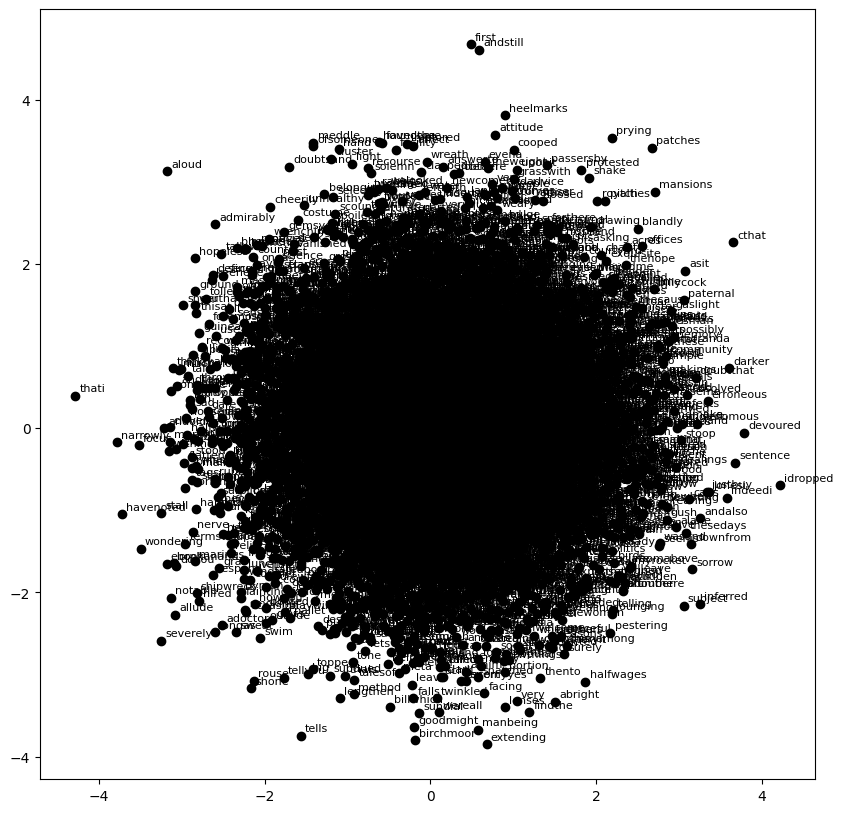

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize embedding layer
embedding_dim = 64  # Make sure this is consistent with your model's embedding size
emb = torch.nn.Embedding(len(stoi), embedding_dim)

# Perform PCA to reduce embedding dimensions to 2 for visualization
def get_2d_embeddings(emb):
    with torch.no_grad():
        pca = PCA(n_components=2)
        emb_2d = pca.fit_transform(emb.weight.detach().cpu().numpy())
    return emb_2d

# Plotting function for 2D embeddings
def plot_emb(emb_2d, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(len(itos)):
        x, y = emb_2d[i]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i], fontsize=8)
    return ax

# Get 2D embeddings and plot
emb_2d = get_2d_embeddings(emb)
plot_emb(emb_2d, itos)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


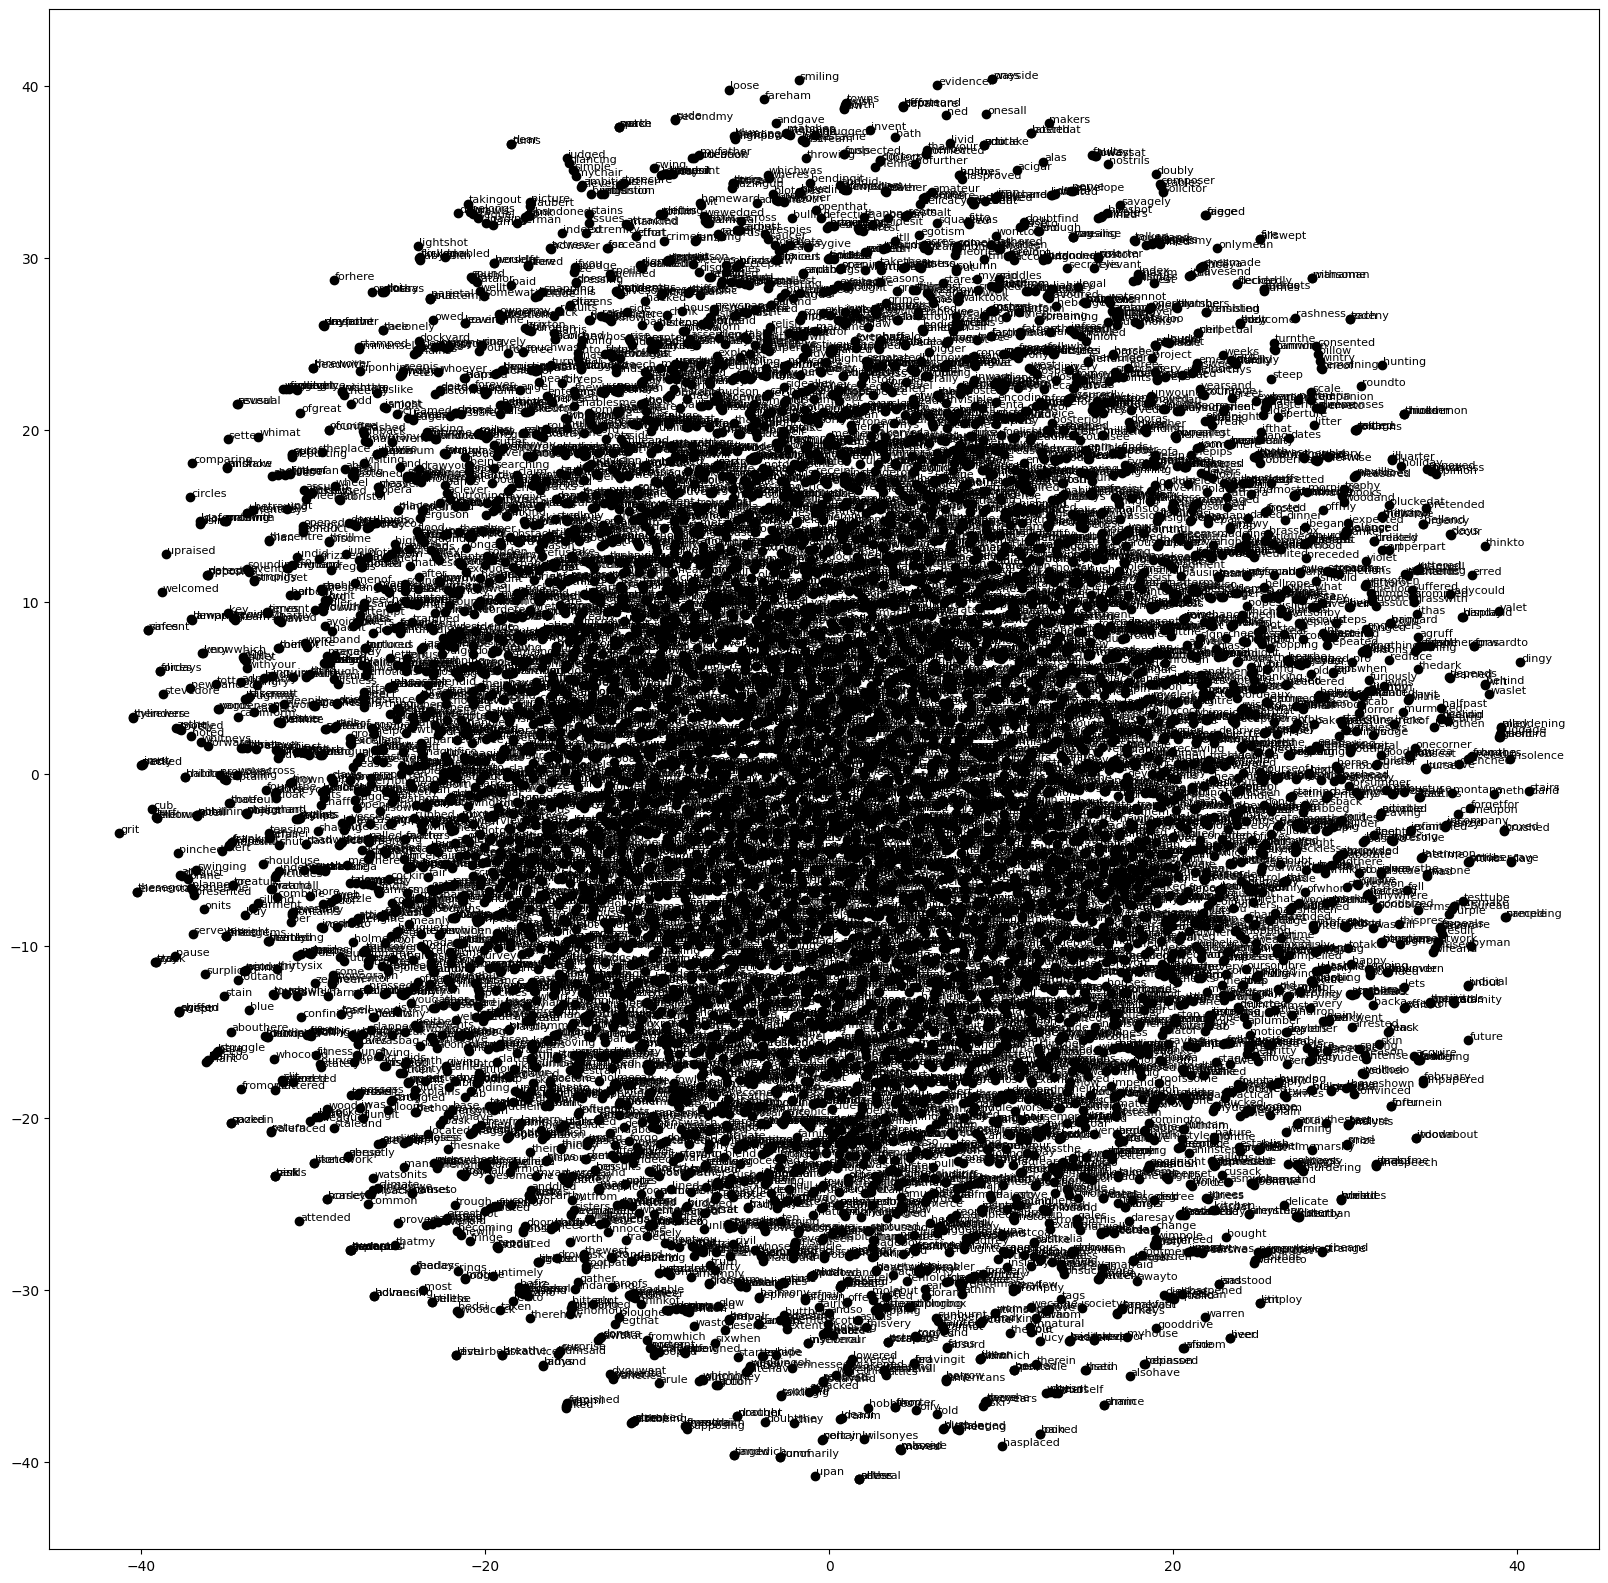

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Initialize embedding layer
embedding_dim = 64  # Ensure this matches your model's embedding dimension
emb = torch.nn.Embedding(len(stoi), embedding_dim)

# Perform t-SNE to reduce embedding dimensions to 2 for visualization
def get_2d_embeddings_tsne(emb):
    with torch.no_grad():
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        emb_2d = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    return emb_2d

# Plotting function for 2D embeddings
def plot_emb_tsne(emb_2d, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 20))
    for i in range(len(itos)):
        x, y = emb_2d[i]
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i], fontsize=8)
    return ax

# Get 2D embeddings and plot
emb_2d_tsne = get_2d_embeddings_tsne(emb)
plot_emb_tsne(emb_2d_tsne, itos)
plt.show()


In [21]:

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, block_size, hidden_size):
        super(NextWordMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(block_size * embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, block_size, embedding_dim)
        x = x.view(x.shape[0], -1)  # Flatten to (batch_size, block_size * embedding_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output logits for each word in the vocabulary
        return x

# Instantiate the model
model = NextWordMLP(vocab_size, embedding_dim, block_size, hidden_size).to(device)



In [22]:
# Generate words from untrained model
import torch

# Initialize model with same parameters
model = NextWordMLP(vocab_size, embedding_dim, block_size, hidden_size).to(device)
model = torch.compile(model)

# Set random generator for reproducibility
g = torch.Generator()
g.manual_seed(4000002)

def generate_words(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size  # Initialize context with padding (assuming index 0 is padding)
    sentence = []

    for _ in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)

        # Sample the next word from the probability distribution
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        word = itos[ix]

        if word == '.':  # Use period as sentence end
            break

        sentence.append(word)
        context = context[1:] + [ix]  # Update context window

    return ' '.join(sentence)

# Generate sentences
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


ismature twentysix ivehad plays isas perturbed dislike has cocked slut
sideon irene seeto engaged tidy secureand glances sneer youbut ramblings
hinges youhe pronounce cocked provinces steal swayed articles camefrom halifax
intense speaking simplest absolute refused look stirring wasmaking swear stupid
soles upat ross mapof owncase crippled swan sayhe trove hehi
elbowed bank alongthe male hopethat cruelly delight leftto england rings
shelittle afine veryquiet dragged atwalsall stains thickly logician garment illhave
thecare drawing accepted arein glaring maysuffer spoken aftermy horace widest
ringing thenits bind plumbers mightvery outbreaks out thelascar thenher trained
whose travel harmless drove lamppost providing vivid behind sleepthey passed


In [24]:
# Define loss function and optimizer
batch_size = 64
epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i + batch_size].to(device)
        y_batch = Y_train[i:i + batch_size].to(device)

        # Forward pass
        y_pred = model(x_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            x_val_batch = X_val[i:i + batch_size].to(device)
            y_val_batch = Y_val[i:i + batch_size].to(device)

            # Forward pass
            y_val_pred = model(x_val_batch)

            # Compute loss
            loss = criterion(y_val_pred, y_val_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss / len(X_train):.4f}, Validation Loss: {val_loss / len(X_val):.4f}")

# Function to predict the next word
def predict_next_word(model, context, stoi, itos, device, top_k=5):
    model.eval()
    context_indices = torch.tensor([stoi.get(word, 0) for word in context], dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(context_indices)
    probs = torch.softmax(logits, dim=-1).squeeze()
    top_k_indices = torch.topk(probs, top_k).indices
    return [itos[idx.item()] for idx in top_k_indices]


# Example prediction
context = ['the', 'adventure', 'of', 'sherlock', 'holmes']
next_words = predict_next_word(model, context, stoi, itos, device, top_k=5)
print(f"Given context: {' '.join(context)}")
print(f"Predicted next words: {next_words}")

Epoch 1/10, Training Loss: 0.0023, Validation Loss: 0.2472
Epoch 2/10, Training Loss: 0.0011, Validation Loss: 0.2591
Epoch 3/10, Training Loss: 0.0004, Validation Loss: 0.2623
Epoch 4/10, Training Loss: 0.0003, Validation Loss: 0.2625
Epoch 5/10, Training Loss: 0.0003, Validation Loss: 0.2613
Epoch 6/10, Training Loss: 0.0002, Validation Loss: 0.2626
Epoch 7/10, Training Loss: 0.0002, Validation Loss: 0.2631
Epoch 8/10, Training Loss: 0.0002, Validation Loss: 0.2668
Epoch 9/10, Training Loss: 0.0007, Validation Loss: 0.2833
Epoch 10/10, Training Loss: 0.0063, Validation Loss: 0.2789
Given context: the adventure of sherlock holmes
Predicted next words: ['and', 'his', 'that', 'whether', 'the']


In [ ]:
import streamlit as st
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
# Function to initialize the model
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, block_size, hidden_size, activation_func):
        super(NextWordMLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(block_size * embedding_dim, hidden_size)
        self.activation = activation_func
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Set up Streamlit UI
st.title("Next Word Prediction")
st.sidebar.header("Model Parameters")

# Model parameters with default values
embedding_dim = st.sidebar.slider("Embedding Dimension", 32, 128, 64)
block_size = st.sidebar.slider("Context Length", 1, 10, 5)
hidden_size = st.sidebar.slider("Hidden Layer Size", 512, 2048, 1024)
activation_choice = st.sidebar.selectbox("Activation Function", ["ReLU", "Tanh", "LeakyReLU"])
random_seed = st.sidebar.number_input("Random Seed", min_value=1, max_value=10000, value=42)
top_k = st.sidebar.slider("Top K Predictions", 1, 10, 5)

# Map activation functions to PyTorch functions
activation_dict = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "LeakyReLU": nn.LeakyReLU()}
activation_func = activation_dict[activation_choice]

# Set random seed for reproducibility
torch.manual_seed(random_seed)

# Load the vocabulary
# Ensure that `stoi` and `itos` mappings are created here for vocabulary lookup

# Initialize the model
vocab_size = len(stoi)
model = NextWordMLP(vocab_size, embedding_dim, block_size, hidden_size, activation_func)
model.to(device)

# Define optimizer and loss function
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Function to predict next words
def predict_next_words(model, context, top_k):
    model.eval()
    context_indices = torch.tensor([stoi.get(word, 0) for word in context], dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(context_indices)
    probs = torch.softmax(logits, dim=-1).squeeze()
    top_k_indices = torch.topk(probs, top_k).indices
    return [itos[idx.item()] for idx in top_k_indices]

# User input for the context
context = st.text_input("Enter the context text", "the adventure of sherlock holmes").lower().split()
if st.button("Predict"):
    next_words = predict_next_words(model, context, top_k)
    st.write(f"Top {top_k} predictions: {', '.join(next_words)}")

# Embedding visualization (optional)
if st.sidebar.checkbox("Show Embedding Visualization"):
    # Code for visualizing embeddings can go here
    st.write("Embedding visualization (if enabled)")

